# Anomaly detection using a global normalization

In [1]:
using CABLAB
import Patchwork
Patchwork.load_js_runtime()

In this example we combine the subsample-quantile approach with the extreme event detection methods. We first take some sample grid cells out of the cube, calculate the 40% and 60% quantile to normalize the variables against each other. We also use this subsample to train the optimization parameters used for the extreme event detectioon methods. 

In [2]:
c=Cube("/home/jovyan/work/datacube/cablab-datacube-0.2.2/low-res/")
cdata=getCubeData(c,variable=c.dataset_files,longitude=(-10,35),latitude=(30,65)
,variable=["air_temperature_2m","gross_primary_productivity","latent_energy","precipitation"])
cdata_filled=mapCube(gapFillMSC,cdata)
cdata_anom=mapCube(removeMSC,cdata_filled);

In [3]:
sp=sampleLandPoints(cdata,3000)
spfilled=mapCube(gapFillMSC,sp)
spanom=mapCube(removeMSC,spfilled)

Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Spatial points axis with 3000 points
Variable            Axis with elements: air_temperature_2m gross_primary_productivity latent_energy precipitation 


In [4]:
spquants = mapCube(CABLAB.Proc.Stats.timespacequantiles,readCubeData(spanom),[0.4,0.6])
spquants.data

2×4 Array{Float32,2}:
 -0.541282  -0.0390479  -0.0212384  -0.393704 
  0.541433   0.0214297   0.0308297  -0.0203651

In [5]:
function scaleCubeQuantiles(xout::AbstractVector,xin::AbstractVector,quantiles)
    absm=(abs(quantiles[1])+abs(quantiles[2]))/2
    for i in eachindex(xin)
        xout[i]=xin[i]/absm
    end
end
registerDATFunction(scaleCubeQuantiles,((TimeAxis,),(QuantileAxis,)),(TimeAxis,),inmissing=(:nan,:nan),outmissing=:nan,no_ocean=1);

The we normalize the cube by dividing each value by the absmean of the 40% and 60% quantile.

In [6]:
cdata_norm=mapCube(scaleCubeQuantiles,(cdata_anom,spquants))

Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Lon                 Axis with 180 Elements from -10.0 to 34.75
Lat                 Axis with 140 Elements from 65.0 to 30.25
Variable            Axis with elements: air_temperature_2m gross_primary_productivity latent_energy precipitation 


In [7]:
using StatsBase
function getTrainArray(smallcube)
    dmem=readCubeData(smallcube).data;
    sampletimes=rand(1:506,5000)
    sampleplaces=rand(1:2000,5000)
    trainarray=Float64[dmem[sampletimes[i],sampleplaces[i],j] for i=1:5000,j=1:4]
    nnans=squeeze(mapreducedim(isnan,+,trainarray,2),2)
    trainarray=trainarray[nnans.==0,:];
    trainarray
end
trainarray=getTrainArray(spanom)

4332×4 Array{Float64,2}:
 -0.756636  -0.405727    -0.0191605   -0.0711678
  1.0405     0.148133     0.121507    -0.639413 
  0.422829   0.135026     0.206596     0.510594 
  0.258387   0.679887     0.172002     1.82428  
  0.885787   0.0738016    0.0428821    1.15387  
 -0.146024   0.0824551    0.0422966   -0.238109 
  0.136128  -0.0427125   -0.14652      2.97427  
  1.90796   -0.0723403    0.26815     -1.08142  
 -4.52876   -1.01049     -0.450672    -0.433257 
 -1.11459   -0.272418    -0.111405    -0.841544 
 -0.979983  -0.501384    -0.120347     0.452793 
  2.27421   -1.86393     -1.18147     -0.655262 
 -1.71664    0.248931     0.127736    -0.235185 
  ⋮                                             
 -1.59747    0.147057     0.051466    -0.266021 
 -0.631739  -0.687909    -0.420939     1.71694  
 -2.84469    0.345417    -0.614362    -0.742071 
 -5.34242   -0.0357205   -0.0254978    0.532719 
 -1.29001   -0.049415     0.00561868  -1.22178  
  1.04018    0.0189442    0.0950883   -0.164

In [8]:
addprocs(10);

In [9]:
@time xout2=mapCube(DAT_detectAnomalies!,cdata_norm,["REC", "KDE", "KNN_Gamma"],trainarray)

100.514365 seconds (11.87 M allocations: 895.498 MB, 0.45% gc time)


Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Method              Axis with elements: REC KDE KNN_Gamma 
Lon                 Axis with 180 Elements from -10.0 to 34.75
Lat                 Axis with 140 Elements from 65.0 to 30.25


In [10]:
rmprocs(workers())

:ok

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 
 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0
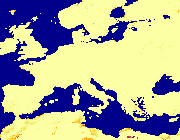

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 
 0.80 
 0.85 
 0.90 
 0.95 
 1.00
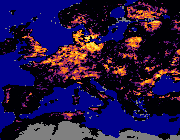

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 
 
 
 40 
 50 
 60 
 70 
 80 
 90 
 100
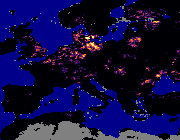

In [20]:
display(plotMAP(xout2,time=160,method=1,dmin=0.5,dmax=1.0))
display(plotMAP(xout2,time=160,method=2,dmin=0.8,dmax=1.0))
display(plotMAP(xout2,time=160,method=3,dmin=40,dmax=100))

In [21]:
meanscore=reduceCube(mean, xout2, TimeAxis, no_ocean=true);

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 0.50 
 0.75 
 1.00
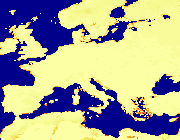

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 0.25 
 0.50 
 0.75
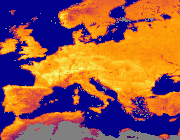

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 10 
 20
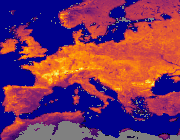

In [22]:
display(plotMAP(meanscore,method=1))
display(plotMAP(meanscore,method=2))
display(plotMAP(meanscore,method=3))

For all methods one can observe the effect of the global normalization. This leads to an overdetection of extremes in the zones where variablility of the underlying variables is highest. 